In [1]:
import sys
sys.path.append('../voicemap/')
sys.path.append('../')
from librispeech import LibriSpeechDataset
from utils import whiten, contrastive_loss, preprocess_instances, BatchPreProcessor
from config import LIBRISPEECH_SAMPLING_RATE
from voicemap.models import get_baseline_convolutional_encoder, build_siamese_net
from keras.optimizers import Adam
import numpy as np
import pandas as pd
from keras.models import load_model
%load_ext autoreload
%autoreload 2

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Initialising all Parameters
n_seconds = 3
downsampling = 4
batchsize = 64
filters = 128
embedding_dimension = 64
dropout = 0.0
input_length = int(LIBRISPEECH_SAMPLING_RATE * n_seconds / downsampling)
#model_path = '../models_e50_cluster/n_seconds/siamese__nseconds_2.0__filters_128__embed_64__drop_0.0__r_0.hdf5'
model_path = '../models_new/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
#model_path = '../models_e50_360_no_multi_2/siamese__filters_128__embed_64__drop_0.0__pad=True_epochs_50_360.hdf5'

In [3]:
#Load model
encoder = get_baseline_convolutional_encoder(filters, embedding_dimension, dropout=dropout)
siamese = build_siamese_net(encoder, (input_length, 1), distance_metric='uniform_euclidean')
opt = Adam(clipnorm=1.)
siamese.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#siamese = load_model(model_path)
siamese.load_weights(model_path)

Instructions for updating:
Colocations handled automatically by placer.


## Encoder


In [4]:
from keras.models import Model
from keras.layers import Input
inputs = Input(shape=(12000,1))

encoded = siamese.layers[2](inputs)
encoder = Model(inputs=inputs, outputs=encoded)
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

In [5]:
#siamese.summary()

In [ ]:
training_set = ['train-clean-100']
train = LibriSpeechDataset(training_set, 3, stochastic=False, pad=True)#, cache=False)
## Validation
validation_set = ['dev-clean']
valid = LibriSpeechDataset(validation_set, 3, stochastic=False, pad=True)#,cache=False)

In [7]:
batch_preprocessor = BatchPreProcessor("classifier", preprocess_instances(downsampling))
preprocessor = batch_preprocessor

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['dev-clean']
Finished indexing data. 2703 usable files found.


##Validation speaker means
val_speaker_list=np.unique(valid.df["speaker_id"])
valid_spkr_means=[]
for speaker in val_speaker_list:
    spkr_index=valid.df[valid.df["speaker_id"]==speaker].index.values
    emb=[]
    for ind in spkr_index:
        query_instance = preprocessor.instance_preprocessor(
                valid[ind][0].reshape(1, -1, 1)
            )
        emb.append(query_instance)
    mean_spkr_embedding=np.mean(emb, axis=0)
    valid_spkr_means.append(mean_spkr_embedding)


- Split the train into train and valid
- and measure accuracy

In [55]:
import soundfile as sf
inst, sr = sf.read(train.df['filepath'][0])
block_size = sr*3
abc =[]
for b in sf.blocks(train.df['filepath'][0], blocksize=block_size, overlap=block_size//2):
    print(len(b))


48000
48000
48000
48000
48000
48000
48000
31440


In [8]:
# Changed from train to valid
## Split the train filenames to train, val_speakers
from sklearn.model_selection import train_test_split
speaker_list=train.df["speaker_id"]
train_arr_filenames=train.df['filepath']
print(train_arr_filenames.shape)
indices = np.arange(len(train_arr_filenames))
ind_train, ind_test = train_test_split(indices, test_size=0.33, random_state=42)
train_arr_filenames[ind_train]
X_train_files = train_arr_filenames[ind_train]
X_test_files = train_arr_filenames[ind_test]
y_train = speaker_list[ind_train]
y_test = speaker_list[ind_test]

(28442,)


In [10]:
## Split the train to train, val_speakers
import pdb
from sklearn.model_selection import train_test_split
speaker_list=np.unique(train.df["speaker_id"])
train_spkr_means=[]
#for speaker in speaker_list:
#spkr_index=train.df[train.df["speaker_id"]==speaker_list[0]]
train_arr=[]
for ind in range(len(train.df)):
    train_arr.append(train[ind])
train_arr=np.array(train_arr)
print(train_arr.shape)
X_train, X_test, y_train, y_test=train_test_split(train_arr[:,0],train.df["speaker_id"], test_size=0.33, random_state=42)

KeyboardInterrupt: 

In [8]:
import pandas as pd
train_=pd.read_csv('train_split.csv')
val_=pd.read_csv('val_split.csv')

In [ ]:
import pandas as pd
train_=pd.DataFrame({"X_train": X_train, "speaker_id":y_train})
val_=pd.DataFrame({"X_test": X_test, "speaker_id":y_test})
#train_.to_csv('train_split.pkl')
#val_.to_csv('val_split.pkl')

In [1]:
train_["X_train"].shape

NameError: name 'train_' is not defined

In [21]:
#Computing the mean of each speaker encoding
speaker_list=np.unique(train_["speaker_id"])
train_spkr_means=[]
for speaker in speaker_list:
    spkr_index=train_[train_["speaker_id"]==speaker].index.values
    emb=[]
    for ind in spkr_index:
        query_instance = preprocessor.instance_preprocessor(
                train_["X_train"][ind].reshape(1,-1,1)
            )
        emb.append(encoder.predict(query_instance))
    mean_spkr_embedding=np.mean(emb, axis=0)
    train_spkr_means.append(mean_spkr_embedding)
train_spkr_means=np.stack(train_spkr_means)


In [28]:
#import pickle
#with open('train_spkr_means_e35_full.pkl', 'wb') as f:
#    pickle.dump(train_spkr_means, f)
#with open('train_spkr_list_e35_full.pkl', 'wb') as f:
#    pickle.dump(speaker_list, f)

In [56]:
import pickle
with open('train_spkr_means_cluster.pkl', 'rb') as f:
    train_spkr_means = pickle.load(f)
with open('train_spkr_list_cluster.pkl', 'rb') as f:
    speaker_list=pickle.load(f)

In [9]:
x=train_spkr_means
x=x.reshape(250,64,-1)
train_spkr_means

AttributeError: 'list' object has no attribute 'reshape'

In [82]:
(np.power((train_spkr_means-query_emb),2)).sum(axis=1).sum(axis=1).shape

(250,)

In [47]:
#trained_spkr_embeddings=trained_speakers["mean_embedding"]
#num_classes = len(np.unique(trained_speakers["speaker_id"]))
#trained_spkr_embeddings=train_spkr_means
#num_classes = len(np.unique(speaker_list))
correct=0
for ind in val_.index.values:
    query_instance = preprocessor.instance_preprocessor(
                val_["X_test"][ind].reshape(1, -1, 1)
            )
    query_emb=encoder.predict(query_instance)
    # Get euclidean distances between mean embeddings
    pred = np.sqrt(
        np.power(
            (
                train_spkr_means-query_emb
            ),
            2,
        ).sum(axis=1).sum(axis=1)
    )
    #print(np.argmin(pred),val_["speaker_id"][ind],ind)
    if speaker_list[np.argmin(pred)] == val_["speaker_id"][ind]:
        correct+=1
    print(speaker_list[np.argmin(pred)], val_["speaker_id"][ind])
print("Num correct", correct)
print("total", len(val_))

1263 669
19 19
460 7190
5678 5678
4195 2196
4362 6415
233 2836
7078 4051
831 5463
8238 839
2007 8975
4214 32
7226 5456
298 1898
3607 1743
3240 5750
6019 7517
2518 6925
8063 5703
78 2843
1867 4406
7190 6081
332 27
4362 1088
1363 226
2817 3983
3723 78
5022 696
8238 233
2159 1624
8238 4680
7078 7078
4853 7511
150 7402
1447 5339
2391 83
4340 2910
4481 1069
2182 1926
7226 6367
6078 2416
2514 2911
441 5778
7800 1841
7780 1502
1963 2764
248 1926
6181 6848
3807 118
1116 7078
1447 2092
6476 2182
2843 1455
2416 8238
730 4481
3486 3607
3440 211
669 4481
839 445
4853 7511
32 5688
6181 412
374 8238
1098 426
5022 3235
298 298
248 211
211 3112
250 2196
3240 3240
441 8123
8838 6818
3235 2817
887 8051
5192 27
3214 3214
2007 302
4214 1246
5390 1447
5561 8324
4859 2952
6181 3699
8629 2893
3947 3947
909 5463
2289 1334
103 8238
39 3982
7447 7447
6000 6000
2007 1363
7148 2764
6181 6181
4160 6064
1447 2989
4406 4830
4859 4859
6563 8095
32 4051
1841 5688
2817 4680
8014 5652
87 2910
1553 3440
6019 322
887 7402

7226 6367
8014 2092
2843 2893
250 3526
3240 3240
2518 6529
481 2843
445 445
587 6064
6019 6019
3242 8580
7800 7800
8580 7226
2007 2007
3607 460
1898 1553
4481 8465
887 7302
3664 3664
7078 2764
4362 6415
2518 6925
8014 1553
8838 8838
1992 1502
8063 8063
7447 7447
8108 1334
4680 7178
6385 198
2836 4297
6415 2182
27 27
3242 8580
26 1334
1898 248
3857 6415
3723 254
226 1363
7780 7780
4397 458
4267 3486
481 307
831 5456
887 8051
4481 3374
1098 8468
2764 1737
4362 1088
6531 6531
1069 669
26 7278
460 7190
5867 5339
3830 3830
4014 4267
26 8088
8770 118
32 32
6081 254
1183 8609
4362 1088
587 587
4813 7517
4362 3983
7148 6272
2007 302
1034 311
1246 4137
87 250
4397 7278
2817 5339
198 2910
6000 6476
2416 1363
6078 125
5022 248
4137 4137
4160 4137
7794 6078
1926 298
7190 2843
150 233
2391 4137
4853 5789
3436 2289
2911 2518
6181 6181
87 87
1088 6078
1867 8123
625 311
4214 4214
5778 5778
8312 6385
4898 163
4362 1088
254 2289
8747 8747
8465 3879
6880 6880
3374 911
6531 4481
730 5789
2989 4088
5678 21

6000 6000
1034 5049
2514 2514
458 2289
7447 7447
5688 4137
1963 4051
374 8324
78 6081
254 8098
32 87
5163 2836
4214 83
403 3947
1594 1594
669 4137
8238 374
8747 3723
3486 118
412 412
226 2989
6531 4481
328 8324
1334 2289
289 229
322 1867
5049 2002
6415 6272
5192 8088
83 32
2518 307
8609 1040
7278 460
40 4640
8226 7264
1098 3982
7780 1992
5022 211
8098 8098
1594 332
4859 4859
839 5561
2518 3807
2691 8770
3807 3807
7148 1867
6848 2911
3436 1455
426 1355
4397 163
1034 1081
3830 4859
2416 3947
7511 1088
5022 8468
1069 40
1841 8324
6147 1737
322 200
8238 1116
2952 4859
1098 1098
4830 1235
2836 8419
1363 4160
1334 4898
233 7148
1898 4088
2416 4481
4214 4214
1183 587
1263 8629
3857 2436
4014 911
7635 696
3235 328
328 5393
3240 3240
3982 302
289 1553
2514 4441
445 445
6476 3235
1263 307
4680 4680
4788 5463
831 730
2007 1553
8123 1898
1246 887
1502 1502
3214 3168
4267 5808
2416 5561
2196 1963
6181 6181
2002 1081
4340 211
5750 5750
4441 6454
7511 7800
6272 2691
298 1553
1723 460
1183 3526
26 269

3259 6078
2989 3526
3723 254
6531 6531
8838 7302
3699 3240
3723 2436
3374 7367
4640 4362
3240 3240
5339 5339
3607 445
441 441
5192 5192
5808 7264
7078 2764
6531 3879
5561 3486
2136 2911
7264 5808
3374 1723
887 1363
1737 2910
587 6064
7190 3807
4195 3947
87 87
298 3112
125 6272
8123 1926
39 1553
8051 2391
2518 6836
6848 5104
7059 7059
374 6078
201 6848
1970 7780
87 226
7367 4014
3664 1447
2843 2843
4397 4397
3240 3240
6147 6147
27 2002
4160 83
6529 6367
233 1040
426 8838
7505 7278
4214 5652
4160 4160
7517 7312
198 3112
1040 1743
4397 7278
7059 3982
8468 7517
5390 196
625 5750
2007 3526
5703 5703
8014 322
5514 5688
248 4297
5322 3436
8014 8014
4214 5652
3947 7794
4788 8797
730 5789
118 5561
4441 6925
5808 4481
4362 4640
328 2182
6272 2989
4898 3857
5867 8465
7067 6563
8425 8425
8468 426
6563 831
39 39
40 7794
7264 7505
2893 4014
233 7148
1926 2910
8609 4859
8095 8629
8051 887
311 2436
2384 118
7859 6818
6848 2384
4214 4640
4088 3526
403 730
2952 446
4898 8108
4441 5678
8051 7178
887 887


KeyboardInterrupt: 

In [48]:
correct/len(val_)
#val_["X_test"][96].reshape(1,-1,1)

0.05508203707649691

In [47]:
#import matplotlib.pyplot as plt
speaker_list[np.argsort(pred)]

array([  32,   87, 1246, 4859,  150, 1963, 4137, 2836, 1737, 2391, 3168,
       8051, 5688, 4051,  198, 1116, 5163, 2007,  211, 3526,  587, 5514,
       4340, 1926,   19, 4088, 6147, 5652, 4297, 7059, 4214,  250, 8609,
       2196,  125, 6000, 2416, 1898, 6078, 4160, 3440, 2989, 4680,  298,
       3607, 1183, 7800, 8975, 4640, 7078,  103, 2817,   83, 7511, 1040,
       1363, 3486, 6064,  248, 7178, 2910,  289, 7402,   40, 6272, 1088,
        839, 2952, 2764, 1594, 1723, 7148, 4195,  887, 3259, 1578, 5393,
       5561,  226,  460, 8238, 8419, 1743, 7367, 6531, 1841, 3947,   39,
       4362, 7859, 6385, 1553, 7794, 1970, 4853, 6476, 2182, 5022, 8014,
       1069,  302, 2092, 2691, 3982, 7067,  374, 3112,   89, 4406,  200,
        445, 1263, 3879, 8465, 3664,  669,  328, 7780,  229, 7190, 8838,
       1867, 6818, 6415, 3830, 7635, 8324, 5322, 3983,  233,  446, 8312,
       3235,  332, 8123,  441, 7113, 5808, 4481,  696,  118, 1992, 5192,
       7302, 5789, 3214, 2843,  311, 4830, 8468, 65

In [177]:
def compute_distances_no_loops(A, B):
    dists = -2 * np.dot(A, B.T) + np.sum(B**2,    axis=1) + np.sum(A**2, axis=1)[:, np.newaxis]
    return dists
A=train_spkr_means.reshape(-1,64)

In [185]:
count=0
val_spkr =np.unique(val_["speaker_id"])
acc=[0]*val_spkr
res=[]
for i in range(len(val_spkr)):
    spkr1=val_[val_["speaker_id"] == val_spkr[i]]["X_test"]
    spkr1.reset_index(drop = True)
    spkr1_=np.stack(x for x in spkr1.reset_index(drop = True))
    spkr1_instance = preprocessor.instance_preprocessor(
                    spkr1_[:,:,np.newaxis] )
    spkr1_emb=encoder.predict(spkr1_instance)
    B=spkr1_emb
    pred=compute_distances_no_loops(A, B).T
    pred_spkrs,counts = np.unique(speaker_list[np.argmin(pred, axis=1)],return_counts = True )
    if pred_spkrs[np.argmax(counts)] == val_spkr[i]:
        count+=1
    res.append([i,pred_spkrs, counts,val_spkr[i]])

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [ ]:
#query_sample, support_set_samples = train.build_n_shot_task(5, 1)
y_val

# Classifier of Embeddings

In [9]:
def read_data(input_data, train=train):
    X_array =[]
    for i in input_data.index.values:
        #instance, sr = sf.read(input_data[i])
        instance, sp = train[i]
        X_array.append(instance)
    X_array = np.array(X_array)
    return X_array

In [10]:
def extract_embedding(X_array, encoder):
    query_instance_ = preprocessor.instance_preprocessor(X_array[:,:,np.newaxis])
    emb = encoder.predict(query_instance_)
    return emb

In [11]:
## Changed from train to valid
X_read = read_data(X_train_files, train)
print(X_read.shape)
val_read = read_data(X_test_files,train)
print(val_read.shape)

(19056, 48000)
(9386, 48000)


In [12]:
emb = extract_embedding(X_read, encoder)

In [50]:
#X_array=np.stack(x for x in train_["X_train"])
#query_instance_ = preprocessor.instance_preprocessor(X_array[:,:,np.newaxis])
#emb = encoder.predict(query_instance_)

In [217]:
#val_array=np.stack(x for x in val_["X_test"])
#val_["X_test"][:].as_matrix().shape

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [13]:
val_emb = extract_embedding(val_read, encoder)

In [14]:
from sklearn import svm
#extract_embedding(train_["X_train"])
X_tr = emb
y_tr = y_train
clf = svm.SVC(gamma = 'scale', probability=True)
clf.fit(X_tr, y_tr) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
y_pred = clf.predict(val_emb)
y_val = y_test
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.8666098444491797


In [16]:
probs = clf.predict_proba(val_emb)

In [101]:
isinstance(X_train_files,pd.core.series.Series)
#type(X_train_files)

(array([0.00265503, 0.00192261, 0.00170898, ..., 0.0055542 , 0.00411987,
        0.00460815]), 19)

In [113]:
import soundfile as sf
def predict(input_data, encoder=encoder, classifier=clf, train=train, X_train_files=X_train_files):
    if isinstance(input_data,pd.core.series.Series):
        X_read = read_data(input_data, train)
    elif isinstance(input_data,str):
        if input_data in train.df['filepath'].values:
            X_read, _ = train[train.df[train.df['filepath'].values==input_data].index.values[0]]
            X_read = X_read.reshape(1,-1)
    #print(X_read.shape)
    X_emb = extract_embedding(X_read, encoder)
    y_pred = clf.predict(X_emb)
    probs = clf.predict_proba(X_emb)
    return y_pred, probs

In [115]:
pred_, pred_probs = predict(X_train_files[0], encoder, clf, train)

(1, 48000)


In [17]:
correct_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] == y_val]
incorrect_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] != y_val]

##Unknown
unknown, sr = valid[100]
query_instance_ = preprocessor.instance_preprocessor(unknown.reshape(1,-1,1))
emb_unknown = encoder.predict(query_instance_)
probs_unknown = clf.predict_proba(emb_unknown)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2)
ax[0,0].plot(correct_probs[0],'g')
ax[0,0].set_ylabel('Probability')
ax[0,0].set_xlabel('Speaker class')
ax[0,0].set_title('Correct Classification')

ax[0,1].plot(incorrect_probs[0], 'r')
ax[0,1].set_ylabel('Probability')
ax[0,1].set_xlabel('Speaker class')
ax[0,1].set_title('Misclassification')

ax[1,0].plot(probs_unknown[0],'b')
ax[1,0].set_ylabel('Probability')
ax[1,0].set_xlabel('Speaker class')
ax[1,0].set_title('Unknown speaker')

ax[1,1].plot(correct_probs[0],'g')
ax[1,1].plot(incorrect_probs[100], 'r')
ax[1,1].plot(probs_unknown[0],'b')
ax[1,1].set_ylabel('Probability')
ax[1,1].set_xlabel('Speaker class')
ax[1,1].legend(['Correct', 'Misclassify', 'Unknown'],fontsize =4, loc=1)
ax[1,1].set_title('Combined')
plt.tight_layout()
plt.show()
fig.savefig('plots_3sec.png', dpi=250)

<Figure size 640x480 with 4 Axes>

In [26]:
#Compute kurosis
from scipy.stats import kurtosis
kurtosis(probs_unknown, axis=1)
kurtosis(probs, axis = 1)
correct_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] == y_val]
incorrect_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] != y_val]
print("Kurtosis for correct predictions: Mean:", np.mean(kurtosis(correct_probs, axis=1)), 
      "Std:", np.std(kurtosis(correct_probs, axis=1)),
      "\nKurtosis for incorrect predictions: Mean:",
      np.mean(kurtosis(incorrect_probs, axis =1)), "Std:",
      np.std(kurtosis(incorrect_probs, axis=1)),
      "\nKurtosis of one Unknown file:",
      kurtosis(probs_unknown, axis=1))
#probs_unknown


Kurtosis for correct predictions: Mean: 203.82340640261293 Std: 49.87805813441787 
Kurtosis for incorrect predictions: Mean: 123.20446374862435 Std: 53.5608958446859 
Kurtosis of one Unknown file: [162.16805625]


In [89]:
print(np.mean(np.max(correct_probs, axis=1)), np.std(np.max(correct_probs, axis=1)))
print(np.mean(np.max(incorrect_probs, axis=1)), np.std(np.max(incorrect_probs, axis=1)))

np.mean(np.max(probs_unknown, axis=1))

0.5089594407023855 0.1696853479744132
0.3110568836946897 0.136879459739754


0.2530405171933147

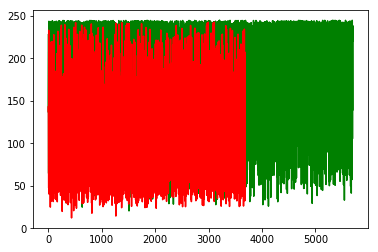

In [251]:
plt.plot(kurtosis(correct_probs, axis =1), 'g')
plt.plot(kurtosis(incorrect_probs, axis=1), 'r')
plt.plot(kurtosis(probs_unknown, axis=1),'b')

In [23]:
def plot_confusion_matrix(cm,classes,
                          title=None,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(250,250))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
classes = np.arange(250)
plot_confusion_matrix(cm,classes,title='Confusion matrix')
#plt.show()

In [ ]:
#models_e50_cluster, Models_e50_full, #Models_new, n=1seconds, n=2seconds,
0.031216, 0.005327, 0.867, 0.25708, 0.1867

### Num-speakers

In [18]:
# num_speakers = 2
# two_spkr = np.random.choice(np.unique(y_train),num_speakers)
def num_speakers_train(X_train_files, y_train, two_spkr, emb=None):
    X_two_train =[]
    y_two_train =[]
    if emb is None:
        spkr1=X_train_files[y_train == two_spkr[0]]
        spkr1_emb = extract_embedding(spkr1, train)
    else:
        spkr1_emb = emb[y_train == two_spkr[0]]
    X_two_train = spkr1_emb
    y_spkr1 = np.stack([two_spkr[0]]*len(spkr1_emb))
    y_two_train = y_spkr1
    
    for i in range(1, len(two_spkr)):
        if emb is None:
            spkr1=X_train_files[y_train == two_spkr[i]]
            spkr1_emb = extract_embedding(spkr1, train)
        else:
            spkr1_emb = emb[y_train == two_spkr[i]]
        y_spkr1 = np.stack([two_spkr[i]]*len(spkr1_emb))
        X_two_train = np.vstack((X_two_train,spkr1_emb))
        y_two_train = np.hstack((y_two_train,y_spkr1))
    #print(X_two_train.shape, y_two_train.shape)
    return (X_two_train, y_two_train)

In [19]:
#num_speakers = 2
#two_spkr = np.unique(y_t)[0:num_speakers]
def num_speakers_val(X_test_files, y_test, two_spkr, val_emb = None):
    X_two_val =[]
    y_two_val =[]
    if val_emb is None:
        spkr1=X_test_files[y_test == two_spkr[0]]
        spkr1_emb = extract_embedding(spkr1, train)
    else:
        spkr1_emb = val_emb[y_test == two_spkr[0]]
    X_two_val = spkr1_emb
    y_spkr1 = np.stack([two_spkr[0]]*len(spkr1_emb))
    y_two_val = y_spkr1

    for i in range(1, len(two_spkr)):
        if val_emb is None:
            spkr1=X_test_files[y_test == two_spkr[i]]
            spkr1_emb = extract_embedding(spkr1, train)
        else:
            spkr1_emb = val_emb[y_test == two_spkr[i]]
        y_spkr1 = np.stack([two_spkr[i]]*len(spkr1_emb))
        X_two_val = np.vstack((X_two_val,spkr1_emb))
        y_two_val = np.hstack((y_two_val,y_spkr1))
    #print(X_two_val.shape, y_two_val.shape)
    return (X_two_val, y_two_val)

In [21]:
from sklearn.metrics import accuracy_score
num_speakers = 3
##Try multiple times and average out
num_reps = 5
acc=[]
print("Num Speakers:", num_speakers)
for i in range(num_reps):
    two_spkr = np.random.choice(np.unique(y_train),num_speakers)
    #print("Trial:", i)
    #, "Speakers:", two_spkr)
    X_two_train, y_two_train = num_speakers_train(X_train_files, y_train, two_spkr, emb)
    clf2 = svm.SVC(gamma = 'scale', probability=True)
    clf2.fit(X_two_train, y_two_train) 
    
    X_two_val, y_two_val = num_speakers_val(X_test_files, y_test, two_spkr, val_emb)
    y_pred = clf2.predict(X_two_val)
    y_val = y_two_val
    acc.append(accuracy_score(y_val, y_pred))
    #print("Accuracy:",acc[i])
print(np.mean(np.array(acc)), np.std(np.array(acc)))

Num Speakers: 3
0.9983739837398374 0.003252032520325221


In [62]:
# emb_05sec_new = emb
# val_05sec_new = val_emb

emb_25sec_new = emb
val_25sec_new = val_emb



## Plot and gif

In [57]:
import soundfile as sf

In [25]:
#Create a combines audio file of randomly selected files
f1 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[0]].index.values[0]]
f2 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[1]].index.values[0]]
f3 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[2]].index.values[0]]
files = [f1, f2, f3]
data = [0]
for f in files:
    inst, sr = sf.read(f)
    data = np.concatenate((data,inst))
data.shape
sf.write('new_combined_file.flac', data, sr)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

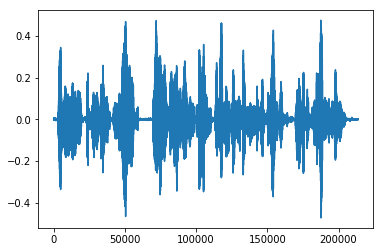

In [56]:
plt.plot(sf.read(f1)[0])

In [28]:
import soundfile as sf
filepath = '/Users/sanmathikamath/projects/datasets/arctic/combined_Librispeech_full_89_4014_8770.flac'
files = ['new_combined_file.flac']
inst, sr = sf.read(filepath)
block_size = sr*3
# blocks_ = np.zeros(block_size)
instances = []
for f in files:
    blocks = sf.blocks(f, blocksize=block_size, overlap = block_size - sr)
    for j in blocks :
        instances.append(j)
    instances = instances[:-1]

instances=np.array(instances)
prob_two = clf2.predict_proba(extract_embedding(np.array(instances), encoder))
prob_two.shape

(28, 3)

In [29]:
y_two = np.argmax(prob_two, axis=1)

In [124]:
cumulative_prob_two = np.zeros(prob_two.shape)
cumulative_prob_two[0]= prob_two[0]
for i in range(1,len(prob_two)):
    cumulative_prob_two[i] = (prob_two[i]+cumulative_prob_two[i-1])/np.sum(prob_two[i]+cumulative_prob_two[i-1])
    #print(cumulative_prob_two[i])
prob_two[:5], cumulative_prob_two[:5]
#(prob_two[1]+prob_two[0])/np.sum(prob_two[1]+prob_two[0])

(array([[0.28823934, 0.59010184, 0.12165883],
        [0.29529533, 0.58188043, 0.12282424],
        [0.30160162, 0.57841541, 0.11998296],
        [0.30938837, 0.5746082 , 0.11600344],
        [0.31251849, 0.57677597, 0.11070553]]),
 array([[0.28823934, 0.59010184, 0.12165883],
        [0.29176733, 0.58599113, 0.12224153],
        [0.29668448, 0.58220327, 0.12111225],
        [0.30303642, 0.57840573, 0.11855784],
        [0.30777746, 0.57759085, 0.11463169]]))

In [30]:
prob_two = clf2.predict_proba(X_two_val)

In [38]:
import matplotlib.cbook as cbook
img_file_path ='/Users/sanmathikamath/projects/Speaker_Recognition/voicemap-master/notebooks/neutral_C.png'
with cbook.get_sample_data(img_file_path) as image_file:
    imageC = plt.imread(image_file)


In [39]:
images=[imageA,imageB,imageC]

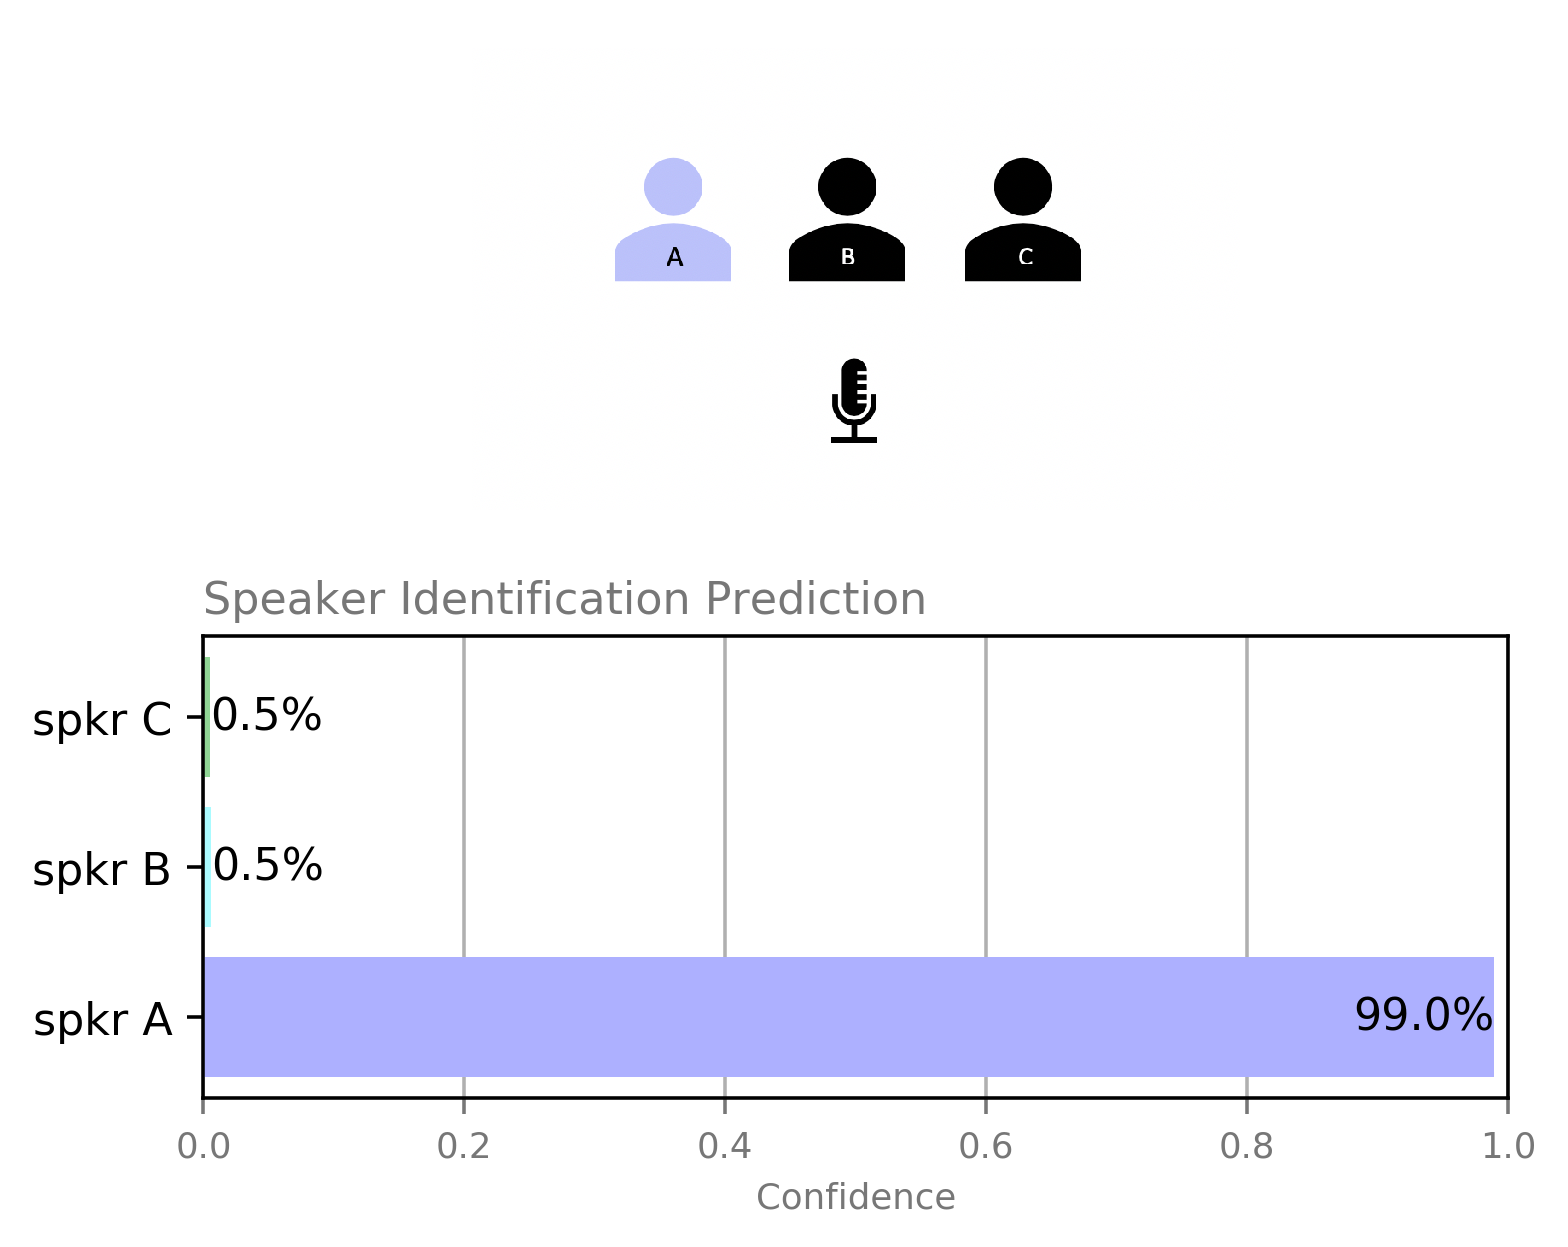

In [53]:
fig, ax = plt.subplots(nrows=2,figsize=(5,4), dpi = 320)
def draw_barchart(sp_i, fig=fig, ax=ax):
    ax[0].imshow(images[y_two[sp_i]])
    ax[0].set_axis_off()
    
    ax = ax[1]
    ax.clear()
    spkr_names_three = ['spkr A', 'spkr B', 'spkr C']
    #spkr_names_three = [str(x) for x in np.unique(y_two_val)]
    colors = dict(zip(
        spkr_names_three,
        ['#adb0ff', '#aafbff', '#90d595']
    ))
    
    ax.barh(spkr_names_three, prob_two[sp_i], color=[colors[x] for x in spkr_names_three])
    ax.set_xlim(0,1)
    # iterate over the values to plot labels and values (Tokyo, Asia, 38194.2)
    for i, (value, name) in enumerate(zip(prob_two[sp_i], spkr_names_three)):
        #ax.text(value, i,     name, size=14, weight=600, ha='right', va='bottom')  # Tokyo: name
        if value < 0.5:
            ax.text(value, i,     str(round(value*100,1))+'%',size=10, ha='left',  va='center')   # 38194.2: value
        else:
            ax.text(value, i,     str(round(value*100,1))+'%',size=10, ha='right',  va='center')   # 38194.2: value
    ax.text(0, 1.05, 'Speaker Identification Prediction',
                transform=ax.transAxes, size=10, weight=100, ha='left',  color='#777777')
    
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    #ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Confidence',color='#777777', size=8)
    #ax.set_ylabel('Speaker')
    ax.tick_params(axis='x', colors='#777777', labelsize=8)
    #ax.text(1, -0.15, 'by @sanmathikamath', transform=ax.transAxes, ha='right', size =6,
    #        color='#777777', bbox=dict(facecolor='white', alpha=0.2, edgecolor='white'))
    
    #ax.set_yticks([])
    #ax.margins(0, 0.01)
    
    #plt.subplots_adjust(left = 0.2, right=0.70,  top=1.1, bottom=0.1 )
    
    plt.box(True)
    plt.tight_layout()
draw_barchart(0, fig, ax)
plt.savefig('overview.png', dpi=250)

IndexError: index 28 is out of bounds for axis 0 with size 28

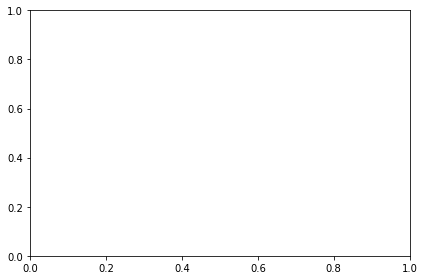

In [52]:
import matplotlib.animation as animation
from IPython.display import HTML
#fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(0,len(prob_two)))
HTML(animator.to_jshtml())
#HTML(animator.save('gif1.mp4'))

two_spkr = np.unique(y_train)[0:2]
X_two_train =[]
y_two_train =[]
#for i in range(len(two_spkr)):
spkr1=train_[train_["speaker_id"] == two_spkr[0]]["X_train"]
spkr1.reset_index(drop = True)
spkr1_=np.stack(x for x in spkr1.reset_index(drop = True))
spkr1_instance = preprocessor.instance_preprocessor(
                    spkr1_[:,:,np.newaxis] )
spkr1_emb=encoder.predict(spkr1_instance)
X_two_train = spkr1_emb
y_spkr1 = np.stack([two_spkr[0]]*len(spkr1))
y_two_train = y_spkr1
print(spkr1_.shape, y_spkr1.shape)
for i in range(1, len(two_spkr)):
    spkr1=train_[train_["speaker_id"] == two_spkr[i]]["X_train"]
    spkr1.reset_index(drop = True)
    spkr1_=np.stack(x for x in spkr1.reset_index(drop = True))
    spkr1_instance = preprocessor.instance_preprocessor(
                        spkr1_[:,:,np.newaxis] )
    spkr1_emb=encoder.predict(spkr1_instance)
    y_spkr1 = np.stack([two_spkr[i]]*len(spkr1))
    print(spkr1_.shape, y_spkr1.shape)
    X_two_train = np.vstack((X_two_train,spkr1_emb))
    y_two_train = np.hstack((y_two_train,y_spkr1))
print(X_two_train.shape, y_two_train.shape)

two_spkr = np.unique(train_["speaker_id"])[0:2]
X_two_val =[]
y_two_val =[]
#for i in range(len(two_spkr)):
spkr1=val_[val_["speaker_id"] == two_spkr[0]]["X_test"]
spkr1.reset_index(drop = True)
spkr1_=np.stack(x for x in spkr1.reset_index(drop = True))
spkr1_instance = preprocessor.instance_preprocessor(
                    spkr1_[:,:,np.newaxis] )
spkr1_emb=encoder.predict(spkr1_instance)
X_two_val = spkr1_emb
y_spkr1 = np.stack([two_spkr[0]]*len(spkr1))
y_two_val = y_spkr1
print(spkr1_.shape, y_spkr1.shape)
for i in range(1, len(two_spkr)):
    spkr1=val_[val_["speaker_id"] == two_spkr[i]]["X_test"]
    spkr1.reset_index(drop = True)
    spkr1_=np.stack(x for x in spkr1.reset_index(drop = True))
    spkr1_instance = preprocessor.instance_preprocessor(
                        spkr1_[:,:,np.newaxis] )
    spkr1_emb=encoder.predict(spkr1_instance)
    y_spkr1 = np.stack([two_spkr[i]]*len(spkr1))
    print(spkr1_.shape, y_spkr1.shape)
    X_two_val = np.vstack((X_two_train,spkr1_emb))
    y_two_val = np.hstack((y_two_train,y_spkr1))
print(X_two_val.shape, y_two_val.shape)

clf2 = svm.SVC(gamma = 'scale')
clf2.fit(X_two_train, y_two_train) 

y_pred = clf2.predict(X_two_val)
y_val = y_two_val
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

In [294]:
np.unique(train_["speaker_id"])[0:10]

array([19, 26, 27, 32, 39, 40, 78, 83, 87, 89])

Text(0,0.5,'Classification Accuracy')

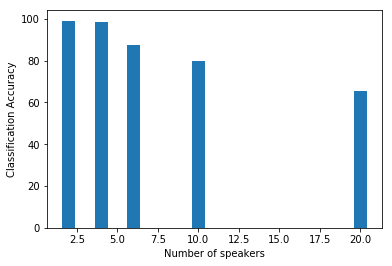

In [307]:
import matplotlib.pyplot as plt
n = [2,4,6,10,20]
acc= [99.07 ,98.56, 87.65, 79.601, 65.539]
plt.bar(n, acc)
plt.xlabel('Number of speakers')
plt.ylabel('Classification Accuracy')

In [161]:
#One vs all Classification
from sklearn.preprocessing import OneHotEncoder
ohe= OneHotEncoder()
ohe.fit(y_train.to_numpy().reshape(-1,1))
y_ohe_train = ohe.transform(y_train.to_numpy().reshape(-1,1))
y_ohe_train.shape

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(19056, 250)

In [18]:
from sklearn import 

'[-0.00030518 -0.00033569 -0.00027466 ...  0.00396729 -0.00341797\n -0.00866699]'

In [15]:
##Extract All embeddings:
spkr_=np.stack(x for x in train_["X_train"].reset_index(drop = True))
spkr_instance = preprocessor.instance_preprocessor(
                    spkr_[:,:,np.newaxis] )
spkr_train_emb=encoder.predict(spkr_instance)


/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


IndexError: too many indices for array

In [ ]:
##Validation embeddings
spkr_=np.stack(x for x in val_["X_test"].reset_index(drop = True))
spkr_instance = preprocessor.instance_preprocessor(
                    spkr_[:,:,np.newaxis] )
spkr_val_emb=encoder.predict(spkr_instance)

In [69]:
for clf_index in range(y_ohe_train.shape[1]):
    clf = svm.SVC(gamma = 'scale')
    
    
    clf.fit(train_["", y_two_train)

(19056, 250)

### Plot of prediction using sliding window 
Splitting one file into its various windows

In [109]:
testing_files_ind = np.random.choice(X_test_files.index.values, 3)
testing_files = X_test_files[testing_files_ind]
testing_files
output_test = y_test[testing_files_ind]
testing_files

11255    /Users/sanmathikamath/projects/voicemap-master...
27001    /Users/sanmathikamath/projects/voicemap-master...
26674    /Users/sanmathikamath/projects/voicemap-master...
Name: filepath, dtype: object

In [110]:
import soundfile as sf
sr = 16000
block_size = n_seconds*sr
output_labels_pred =[]
for file in testing_files:
    print(file)
    blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
    instances=[]
    for j in blocks :
        instances.append(j)
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/2514/149482/2514-149482-0021.flac
/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/8324/286682/8324-286682-0032.flac
/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/8238/283452/8238-283452-0037.flac


In [111]:
output_labels_pred, output_test

([array([3240, 2136, 7264, 7264, 2911, 6181, 2514, 2911, 2911]),
  array([5339,  831, 7226, 6454, 8095, 8095, 6454, 4267,  831]),
  array([ 211,  103,  125, 1116, 1235,  460, 1867, 1116, 8419])],
 11255    2514
 27001    8324
 26674    8238
 Name: speaker_id, dtype: int64)

### Plot of prediction using sliding window over multiple files
Splitting one file into its various windows and combining multiple files of same speaker

In [113]:
test_speakers = np.random.choice(np.unique(y_test), 3)

In [114]:
output_labels_pred =[]
for spkr_j in test_speakers:
    print(spkr_j)
    spkr_j_ind = y_test[y_test == spkr_j].index.values
    spkr_files = X_test_files[spkr_j_ind]
    instances=[]
    for file in spkr_files:
        blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
        for j in blocks :
            instances.append(j)
        instances = instances[:-1]
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

6454
8324
1970


In [110]:
output_labels_pred, test_speakers

([array([ 289, 1867, 1867, 1867, 1867, 1867, 7635, 7635, 1867, 7635, 1867,
         1867, 1867, 1867, 7635, 7635, 1867, 1867, 1867, 1867, 1867,  289,
          289,  289,  289, 1867, 7059, 7059, 7059,   39, 4406, 4406, 4406,
         7635, 7635, 7635, 4406, 1867, 1867, 1867, 1867, 1867, 1867, 1867,
         1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 7059,
          289, 1867, 1867, 4406, 4406, 4406, 3982, 7635, 3982, 3982, 1867,
         7635, 7635, 1867, 4406, 4406, 1867, 1867, 1867, 1867, 3982, 1867,
         7635, 4406, 1867, 1867, 4406, 4406, 4406, 1867, 1867, 4406, 4406,
         1867,  289, 1867, 1867, 7635, 7635, 3982, 3982, 7635, 7635, 1867,
         1867, 7635,  289, 1867, 1867, 4406, 4406, 4406, 1867, 1867, 7635,
         4406, 1867, 1867, 4406, 4406, 1867, 4406, 4406, 3982, 1867, 1867,
         1867, 7635, 1867, 1867,  289, 1867, 1867, 7635, 3112, 2989, 1867,
         7635,   39, 1867, 1867, 1867,   39, 1867, 1867, 1867, 7635, 1867,
         1867, 3982, 1867

In [118]:
from collections import Counter
print("Predicted_label:", Counter(output_labels_pred[0]).most_common(1)[0][0], "\nActual label:",test_speakers[0])

Predicted_label: 6454 
Actual label: 6454


In [149]:
##Unknown speaker predictions for sliding window
unknown = valid.df['filepath'][0]
import soundfile as sf
sr = 16000
n_seconds=3
block_size = n_seconds*sr
output_labels_pred =[]
for file in [unknown]:
    print(file)
    blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
    instances=[]
    for j in blocks :
        instances.append(j)
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/dev-clean/84/121123/84-121123-0026.flac


In [146]:
output_labels_pred

[array([5778, 1502, 8123, 5778, 1502, 1502, 1502, 5778])]

In [150]:
accuracy_score(y_val, y_pred)

0.8666098444491797

In [162]:
# #EER
# from sklearn.metrics import roc_curve
# fpr, tpr, threshold = roc_curve(y_val, y_pred)
# fnr = 1 - tpr
# eer_threshold = threshold(np.nanargmin(np.absolute((fnr - fpr))))
# EER = fpr(np.nanargmin(np.absolute((fnr - fpr))))
# print(EER)

In [163]:
probs = clf.predict_proba(val_emb)
probs

AttributeError: predict_proba is not available when  probability=False

### KMeans Clustering

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time
X_train = emb
from sklearn.decomposition import PCA
#kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=len(data))))

    return estimator

In [42]:
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
km = bench_k_means(KMeans(init='random', n_clusters=250, n_init=10),
              name="random initialization", data=X_train, labels = y_train)
# Reducing to two clusters to plot
# #pca = PCA(n_components=32).fit(X_train.T)
# print(pca.components_.shape)
# bench_k_means(KMeans(init=pca.components_, n_clusters=250, n_init=1),
#               name="PCA-based",
#               data=X_train, labels = y_train)

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
random initialization	15.81s	400260	0.815	0.822	0.818	0.512	0.760	0.213


In [154]:
y_clus = km.predict(X_train)
np.unique(y_clus)

0.00020990764063811922

In [124]:
X_train_files[0:100]

15987    /Users/sanmathikamath/projects/voicemap-master...
9278     /Users/sanmathikamath/projects/voicemap-master...
2993     /Users/sanmathikamath/projects/voicemap-master...
26482    /Users/sanmathikamath/projects/voicemap-master...
4166     /Users/sanmathikamath/projects/voicemap-master...
                               ...                        
16177    /Users/sanmathikamath/projects/voicemap-master...
891      /Users/sanmathikamath/projects/voicemap-master...
1838     /Users/sanmathikamath/projects/voicemap-master...
4193     /Users/sanmathikamath/projects/voicemap-master...
19396    /Users/sanmathikamath/projects/voicemap-master...
Name: filepath, Length: 100, dtype: object

In [140]:
import cProfile
import pstats
cProfile.run('predict(X_train_files[0:100], encoder, clf, train)', "predstats")
p = pstats.Stats('predstats')

(100, 48000)


In [143]:
#cProfile.run('predict(X_train_files[0], encoder, clf, train)')
p.sort_stats('time').print_stats()
#p.dump_stats('pred_stats')

Tue Jan 21 17:37:40 2020    predstats

         14288 function calls (14222 primitive calls) in 6.829 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    4.951    1.238    4.951    1.238 {built-in method _pywrap_tensorflow_internal.TF_SessionRunCallable}
        1    0.805    0.805    0.805    0.805 {sklearn.svm.libsvm.predict_proba}
        1    0.623    0.623    0.623    0.623 {sklearn.svm.libsvm.predict}
      100    0.311    0.003    0.312    0.003 /Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/soundfile.py:1312(_cdata_io)
        1    0.036    0.036    0.048    0.048 ../voicemap/utils.py:92(whiten)
       35    0.020    0.001    0.020    0.001 {built-in method numpy.array}
        1    0.014    0.014    0.387    0.387 <ipython-input-9-07b57d63f96c>:1(read_data)
      104    0.008    0.000    0.008    0.000 {built-in method numpy.empty}
      100    0.008    0.000    0.011    0.000 /Users/sanmathik

NameError: name 'gprof2dots' is not defined